# GD2.CV.프로젝트: ResNet Ablation Study
##### !. Google colab pro를 사용하여 작성되었습니다.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---

### 목차
STEP 0. 주요 라이브러리 import 및 데이터 전처리  
STEP 1. ResNet 기본 블록 구성하기  
STEP 2. ResNet-34, ResNet-50 Complete Model  
STEP 3. 일반 네트워크(plain network)  
STEP 4. ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34  
회고록   
Reference

---

### (서론)


앞선 딥러닝 프로젝트를 진행하며 여러 모델들을 직접 적용하며 결과물을 도출해냈다.  
이번 프로젝트에서는 이런 모델들을 직접 구현해보고 각 기법을 적용했을 때와 아닐 때를 비교해 보는 Ablation study(제거 연구)효과를 직접 확인해보고자 한다.

---

### (본문)

### STEP 0. 주요 라이브러리 import 및 데이터 전처리

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import urllib3
urllib3.disable_warnings()

In [ ]:
print(tf.__version__)
print(pd.__version__)
print(np.__version__)

2.8.2
1.3.5
1.21.6


#### GPU 확인

In [ ]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 보기 위함.
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### 상수 설정

- BATCH_SIZE 가 클수록 훈련 시간 단축, 1 EPOCH 당 1분 이상 소요됨
- 데이터셋 CIFAR-10 의 경우 40 EPOCHS 정도 수행하는 것을 권장, 15 EPOCHS 정도로도 근접한 성능 얻을 수 있음
- batch_size 와 learning_rate 최고의 조합 찾기
 - Best
   - 작은 batch, 낮은 lr (e.g. 16, 0.0001)
   - 큰 batch, 높은 lr (e.g. 256, 0.001)
 - Worst
   - 작은 batch, 높은 lr (e.g. 16, 0.001)
   - 큰 batch, 낮은 lr (e.g. 256, 0.0001)

In [ ]:
BATCH_SIZE = 32  # 256
EPOCHS = 10  # 15
LR = 0.1
OPT_DECAY = 0.0001
MOMENTUM = 0.9
L2_WEIGHT_DECAY = 1e-4
BATCH_NORM_DECAY = 0.9
BATCH_NORM_EPSILON = 1e-5

ACTIVATION = 'sigmoid'
NUM_CLASSES = 1

#### 데이터 가져와서 확인


- ds_info = tfds.load(): 기본적으로 ~/tensorflow_datasets 경로에 데이터셋 다운로드
- Tensorflow의 데이터셋은 Numpy가 아님 => 다른 방법으로 정보 확인해야 함!
  - ds_info.features # feature 정보 확인
  - tf.data.experimental.cardinality(ds_train) # 데이터셋의 이미지 shape와 전체 데이터의 개수, 라벨 클래스의 개수 확인

- 데이터셋 다운로드
  - tfds.load()

In [ ]:
import urllib3
urllib3.disable_warnings()
# 기존 코드 실행시 오류가 나니 아래 코드 추가해서 실행할것.
# 참고링크:https://stackoverflow.com/questions/72199498/error-in-importing-cats-vs-dogs-dataset-in-google-colab
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
# tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않음.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete5HKV6B/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


- 데이터셋 features 확인
  - ds_info: 데이터셋의 메타 정보

In [ ]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인.
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


- 데이터셋 개수 확인
  - Tensorflow 데이터셋은 Numpy 가 아님 => ds_train.shape 사용 불가
  - tf.data.experimental.cardinality(ds_train) 로 확인

In [ ]:
# 데이터의 개수도 확인.
print(tf.data.experimental.cardinality(ds_train))  # tf.Tensor(18610, shape=(), dtype=int64)
print(tf.data.experimental.cardinality(ds_test))  # tf.Tensor(4652, shape=(), dtype=int64)


tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


- 데이터셋 클래스 개수 및 구성 확인

In [ ]:
ds_info.features["label"].num_classes  # 2

2

In [ ]:
ds_info.features["label"].names  # ['cat', 'dog']

['cat', 'dog']

- 각 이미지 클래스와 인덱스 확인
  - 학습용 데이터셋 확인
  - 평가용 데이터셋 확인

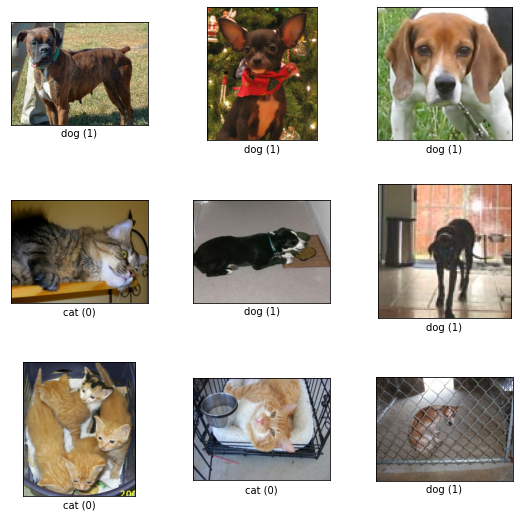

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

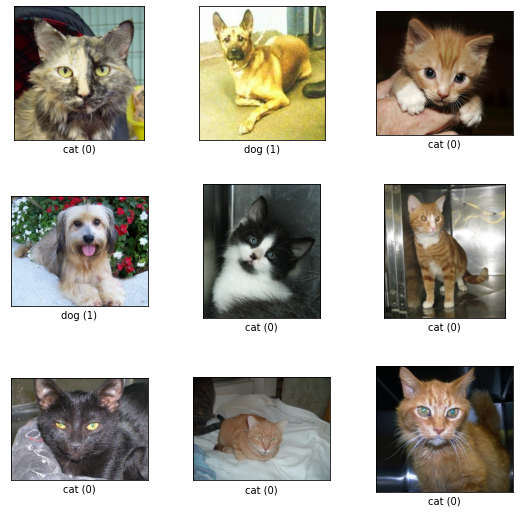

In [ ]:
fig = tfds.show_examples(ds_test, ds_info)

#### Input Normalization

- **Data Normalization**: 데이터의 범위를 사용자가 원하는 범위로 제한하는 것
  - 이미지 데이터의 경우 픽셀 정보를 0~255 사이의 값으로 가지는데, 이를 255로 나누어주면 0 ~ 1.0 사이의 값을 가짐
  - 수식: (정규화하고자 하는 값 - 데이터 값들 중 최소값) / (데이터 값들 중 최대 값 - 데이터 값들 중 최소값)

 - 사용 이유
    - 머신러닝에서. scale이 큰 feature의 영향이 비대해지는 것을 방지
    - 딥러닝에서. Local optimum에 빠질 위험을 줄임(학습 속도 향상)
- scikit-learn에서 MinMaxScaler로 쉽게 사용
  - 모델에 넣어주기 전에 각 채널별 최댓값인 255로 **정규화(normalize)**를 해주어 이미지의 표현이 0과 1 사이로 들어오도록 만들어줌.

- 데이터 전처리
  - 학습 데이터와 검증 데이터에 normalizing 과 resizing 적용

In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

- 전처리 포함한 배치 구성

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

- 데이터셋에 전처리와 배치 처리 적용

In [ ]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

- 구성된 배치 모양 확인

In [ ]:
for input in ds_train.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(32, 224, 224, 3)
(32,)


### STEP 1. ResNet 기본 블록 구성하기

#### ResNet, Plain 구현


- 블록을 단위로 모델을 만들 수 있어야 함!
  - **블록(block)**: 일반적인 딥러닝 모델에서 이렇게 주요 구조를 모듈화 시켜 조금씩 바꾸어 쓸 수 있는 단위
  - **레이어(layer)**: 기본적으로 텐서플로우(TensorFlow), 케라스(Keras), 파이토치(PyTorch) 등에서 기본적으로 제공하는 단위
- ResNet
  - ResNet-18, 34, 50, 101, 152

- Plain: ResNet 에서 Residual Block 이 없는 형태
  - ResNet-34, Plain-34

본 논문의 핵심 아이디어인 Residual Block의 기본 구성은 BasicBlock = Convolution layer + BatchNormalization layer + ReLU가 쌓여서 만들어진 구성을 가지고 있으며, 이를 통해서 block 한 개를 만들 수 있음

#### 블록 생성 함수


In [ ]:
def conv_block(input_layer, 
                channel, 
                kernel_size, 
                strides=1, 
                activation='relu',
                l2_weight_decay=1e-4,
                batch_norm_decay=0.9,
                batch_norm_epsilon=1e-5):
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=kernel_size,
        kernel_initializer='he_normal',
        kernel_regularizer=keras.regularizers.l2(l2_weight_decay),
        padding='same',
        strides=strides,
        use_bias=False,
    )(input_layer)
    
    x = keras.layers.BatchNormalization(
        # momentum=batch_norm_decay,
        # epsilon=batch_norm_epsilon,
    )(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [ ]:
def build_net_block(input_layer, 
                    cnn_count=3, 
                    channel=64, 
                    block_num=0, 
                    is_50=True,
                    is_ResNet=True):

    x = input_layer
    
    # 첫 번째 conv_layer 에서 strides=2 설정해서 너비와 높이를 줄임
    # => 필터의 개수(=채널)가 증가할 때마다 너비와 높이를 줄임

    # ResNet-50, Plain-50
    if is_50:
        if is_ResNet: # ResNet-50
            for i in range(cnn_count):
                if i == 0:
                    shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                    x = conv_block(x, channel, (1,1), strides=2)
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1), activation=None)
                else:
                    shortcut = x
                    x = conv_block(x, channel, (1,1))
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1), activation=None)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
        else:  # Plain-50
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    x = conv_block(x, channel, (1,1), strides=2)
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1))
                else:
                    x = conv_block(x, channel, (1,1))
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1))
    # ResNet-34, Plain-34
    else:
        if is_ResNet:  # ResNet-34
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                    x = conv_block(x, channel, (3,3), strides=2)
                    x = conv_block(x, channel, (3,3), activation=None)
                else:
                    shortcut = x
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel, (3,3), activation=None)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
        else:  # Plain-34
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    x = conv_block(x, channel, (3,3), strides=2)
                    x = conv_block(x, channel, (3,3))
                else:
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel, (3,3))

    return x

#### 모델 생성 함수

In [ ]:
def build_net(input_shape=(32,32,3),
                cnn_count_list=[3,4,6,3],
                channel_list=[64,128,256,512],
                num_classes=10, 
                is_50=True,
                is_ResNet=True,
                activation='softmax',
                name='ResNet_50'):
    
    # 모델 생성 전, config list들이 같은 길이인지 확인
    assert len(cnn_count_list) == len(channel_list)
    
    # input layer 생성
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer 설정
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서
    # - is_ResNet=True 일 경우, Residual block 블록을 생성
    # - is_ResNet=False 일 경우, Plain block 블록을 생성
    for block_num, (cnn_count, channel) in enumerate(zip(cnn_count_list, channel_list)):
        x = build_net_block(x, 
                            cnn_count=cnn_count, 
                            channel=channel, 
                            block_num=block_num, 
                            is_50=is_50,
                            is_ResNet=is_ResNet)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                        activation=activation, 
                        kernel_initializer='he_normal'
                        )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

### STEP 2. ResNet-34, ResNet-50 Comploete Model

#### 모델 생성 및 확인 

- ResNet-34, ResNet-50 생성


In [ ]:
resnet_34 = build_net(
    input_shape=(224,224,3),
    is_50=False,
    is_ResNet=True,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='ResNet_34',
)
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                         

In [ ]:
resnet_50 = build_net(
    input_shape=(224,224,3),
    is_50=True,
    is_ResNet=True,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='ResNet_50',
)
resnet_50.summary()


Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 112, 112, 64  9408        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 112, 112, 64  256        ['conv2d_36[0][0]']              
 ormalization)                  )                                                         

### STEP 3. 일반 네트워크(plain network)

- Plain-34, Plain-50 생성

In [ ]:
plain_34 = build_net(
    input_shape=(224,224,3),
    is_50=False,
    is_ResNet=False,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='Plain_34',
)
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_89 (Conv2D)          (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_89 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_82 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_90 (Conv2D)          (None, 56, 56, 64)        368

In [ ]:
plain_50 = build_net(
    input_shape=(224,224,3),
    is_50=True,
    is_ResNet=False,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='Plain_50',
)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_122 (Conv2D)         (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_122 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_115 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_123 (Conv2D)         (None, 56, 56, 64)        409

### STEP 4. ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

#### ResNet vs Plain 비교

##### 학습
- 모델 학습 함수
  - 데이터셋이 작을 경우, Adam 보다 SGD 가 더 학습에 유리하다.

In [ ]:
def comile_and_fit(model, ds_train, ds_test, ds_info, learning_rate=0.001, momentum= 0.9, opt_decay=0.0001, batch_size=128, epochs=15):
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.SGD(
            learning_rate=learning_rate,
            momentum=momentum,
            decay=opt_decay,
            clipnorm=1.
        ),
        metrics=['accuracy'],
    )

    history = model.fit(
        ds_train,
        steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['train[80%:]'].num_examples/batch_size),
        epochs=epochs,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

    return history

- ResNet-34 학습

In [ ]:
history_resnet_34 = comile_and_fit(resnet_34, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/10
581/581 [==============================] - 100s 128ms/step - loss: 2.3295 - accuracy: 0.5428 - val_loss: 2.1564 - val_accuracy: 0.5000
Epoch 2/10
581/581 [==============================] - 72s 123ms/step - loss: 1.9317 - accuracy: 0.6111 - val_loss: 1.9128 - val_accuracy: 0.5190
Epoch 3/10
581/581 [==============================] - 71s 123ms/step - loss: 1.6565 - accuracy: 0.6569 - val_loss: 1.5906 - val_accuracy: 0.6261
Epoch 4/10
581/581 [==============================] - 72s 123ms/step - loss: 1.4372 - accuracy: 0.6935 - val_loss: 1.6060 - val_accuracy: 0.5818
Epoch 5/10
581/581 [==============================] - 71s 123ms/step - loss: 1.2596 - accuracy: 0.7249 - val_loss: 1.2619 - val_accuracy: 0.6857
Epoch 6/10
581/581 [==============================] - 72s 124ms/step - loss: 1.1126 - accuracy: 0.7532 - val_loss: 1.3433 - val_accuracy: 0.5733
Epoch 7/10
581/581 [==============================] - 72s 124ms/step - loss: 0.9815 - accuracy: 0.7831 - val_loss: 1.1811 - val_a

- Plain-34 학습

In [ ]:
history_plain_34 = comile_and_fit(plain_34, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/10
581/581 [==============================] - 84s 119ms/step - loss: 2.1016 - accuracy: 0.5388 - val_loss: 1.9320 - val_accuracy: 0.5747
Epoch 2/10
581/581 [==============================] - 69s 118ms/step - loss: 1.8072 - accuracy: 0.5615 - val_loss: 1.7039 - val_accuracy: 0.5143
Epoch 3/10
581/581 [==============================] - 69s 118ms/step - loss: 1.5915 - accuracy: 0.5621 - val_loss: 2.4393 - val_accuracy: 0.5414
Epoch 4/10
581/581 [==============================] - 69s 119ms/step - loss: 1.4142 - accuracy: 0.6012 - val_loss: 1.3783 - val_accuracy: 0.5558
Epoch 5/10
581/581 [==============================] - 69s 119ms/step - loss: 1.2722 - accuracy: 0.6237 - val_loss: 1.2956 - val_accuracy: 0.5130
Epoch 6/10
581/581 [==============================] - 69s 119ms/step - loss: 1.1571 - accuracy: 0.6500 - val_loss: 1.1569 - val_accuracy: 0.6375
Epoch 7/10
581/581 [==============================] - 70s 120ms/step - loss: 1.0483 - accuracy: 0.6849 - val_loss: 1.0785 - val_ac

- ResNet-50 학습


In [ ]:
history_resnet_50 = comile_and_fit(resnet_50, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/10
581/581 [==============================] - 80s 105ms/step - loss: 5.8554 - accuracy: 0.5351 - val_loss: 5.0818 - val_accuracy: 0.5938
Epoch 2/10
581/581 [==============================] - 60s 104ms/step - loss: 4.6447 - accuracy: 0.5922 - val_loss: 4.2121 - val_accuracy: 0.6223
Epoch 3/10
581/581 [==============================] - 60s 103ms/step - loss: 3.8653 - accuracy: 0.6453 - val_loss: 3.6121 - val_accuracy: 0.5600
Epoch 4/10
581/581 [==============================] - 60s 104ms/step - loss: 3.2618 - accuracy: 0.6708 - val_loss: 3.3907 - val_accuracy: 0.5360
Epoch 5/10
581/581 [==============================] - 60s 104ms/step - loss: 2.7861 - accuracy: 0.6933 - val_loss: 2.7831 - val_accuracy: 0.5859
Epoch 6/10
581/581 [==============================] - 61s 104ms/step - loss: 2.3832 - accuracy: 0.7336 - val_loss: 2.2553 - val_accuracy: 0.7189
Epoch 7/10
581/581 [==============================] - 61s 104ms/step - loss: 2.0637 - accuracy: 0.7634 - val_loss: 1.9830 - val_ac

- Plain-50 학습


In [ ]:
history_plain_50 = comile_and_fit(plain_50, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/10
581/581 [==============================] - 112s 162ms/step - loss: 4.8888 - accuracy: 0.5037 - val_loss: 4.4011 - val_accuracy: 0.5110
Epoch 2/10
581/581 [==============================] - 93s 160ms/step - loss: 4.0292 - accuracy: 0.5111 - val_loss: 3.6928 - val_accuracy: 0.4861
Epoch 3/10
581/581 [==============================] - 93s 160ms/step - loss: 3.3999 - accuracy: 0.5083 - val_loss: 3.1371 - val_accuracy: 0.4874
Epoch 4/10
581/581 [==============================] - 93s 160ms/step - loss: 2.9122 - accuracy: 0.5120 - val_loss: 2.7076 - val_accuracy: 0.5048
Epoch 5/10
581/581 [==============================] - 94s 161ms/step - loss: 2.5297 - accuracy: 0.5230 - val_loss: 2.3703 - val_accuracy: 0.4981
Epoch 6/10
581/581 [==============================] - 94s 163ms/step - loss: 2.2194 - accuracy: 0.5363 - val_loss: 2.1005 - val_accuracy: 0.5004
Epoch 7/10
581/581 [==============================] - 94s 161ms/step - loss: 1.9621 - accuracy: 0.5740 - val_loss: 1.8685 - val_a

#### 학습 결과 시각화 및 저장
- ResNet-34, Plain-34
 - Training Loss
 - Training Accuracy

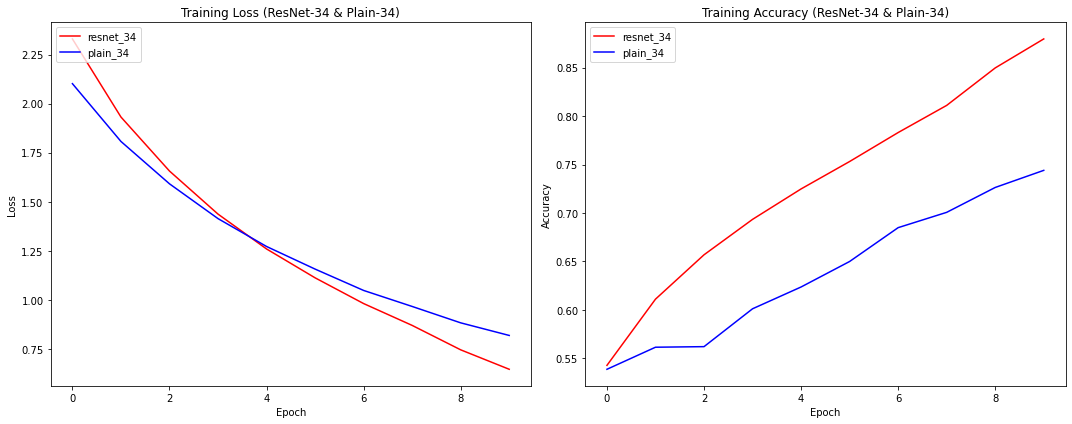

In [ ]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Training Loss (ResNet-34 & Plain-34)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

# ResNet-34, Plain-34 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['accuracy'], 'r')
plt.plot(history_plain_34.history['accuracy'], 'b')
plt.title('Training Accuracy (ResNet-34 & Plain-34)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Training_Loss_and_Accuracy_of_34.png')

plt.show()

- ResNet-50, Plain-50
  - Training Loss
  - Training Accuracy

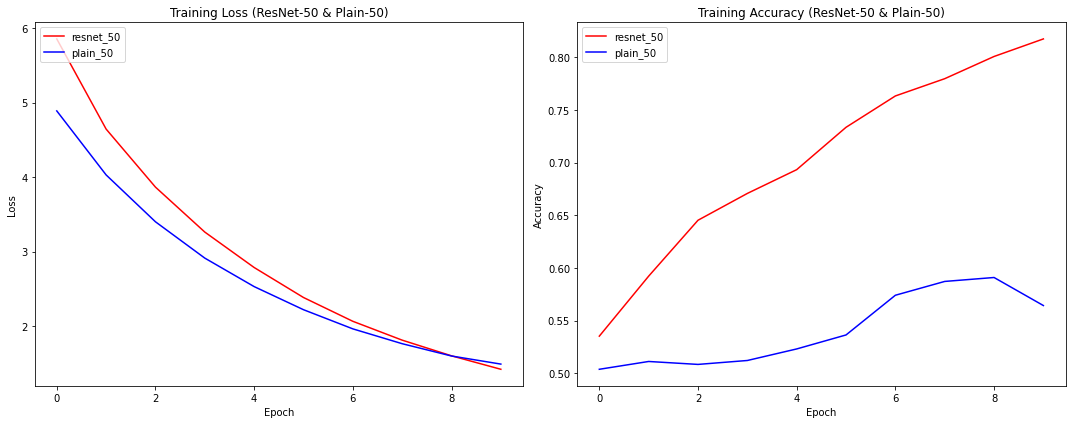

In [ ]:
plt.subplots(figsize=(15,6))

# ResNet-50, Plain-50 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Training Loss (ResNet-50 & Plain-50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

# ResNet-50, Plain-50 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_50.history['accuracy'], 'r')
plt.plot(history_plain_50.history['accuracy'], 'b')
plt.title('Training Accuracy (ResNet-50 & Plain-50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Training_Loss_and_Accuracy_of_50.png')

plt.show()

- ResNet-34, Plain-34, ResNet-50, Plain-50
 - Training Loss
 - Training Accuracy

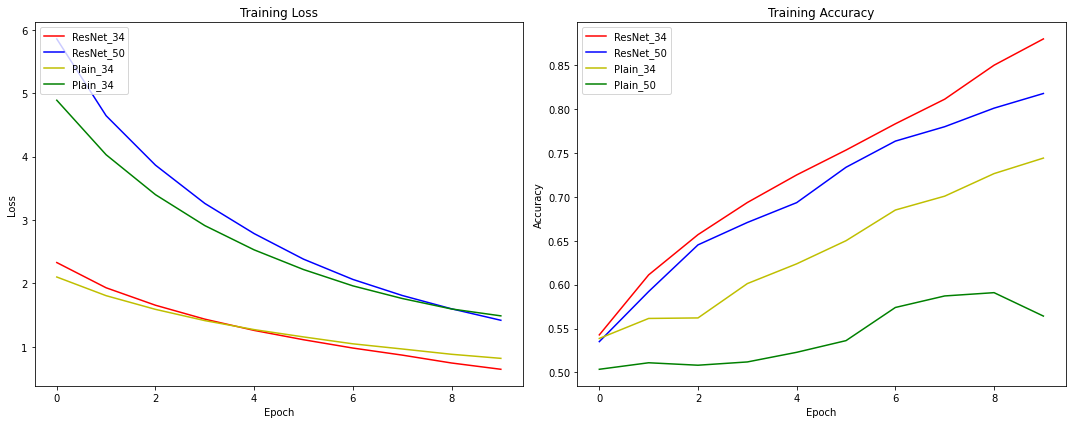

In [ ]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34, ResNet-50, Plain-50 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_resnet_50.history['loss'], 'b')
plt.plot(history_plain_34.history['loss'], 'y')
plt.plot(history_plain_50.history['loss'], 'g')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_34'], loc='upper left')

# ResNet-34, Plain-34, ResNet-50, Plain-50 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['accuracy'], 'r')
plt.plot(history_resnet_50.history['accuracy'], 'b')
plt.plot(history_plain_34.history['accuracy'], 'y')
plt.plot(history_plain_50.history['accuracy'], 'g')
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Training_Loss_and_Accuracy_of_All.png')

plt.show()

- ResNet-34, Plain-34
 - Validation Loss
 - Validation Accuracy

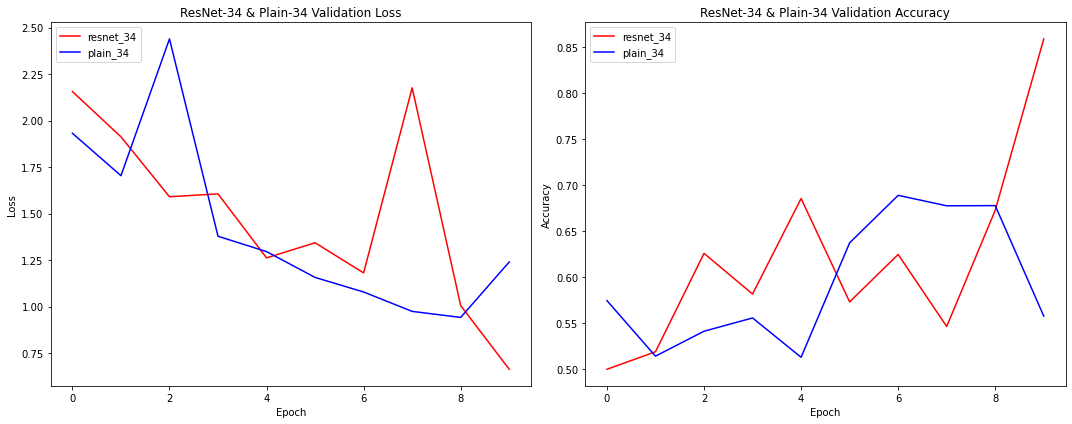

In [ ]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_plain_34.history['val_loss'], 'b')
plt.title('ResNet-34 & Plain-34 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

# ResNet-34, Plain-34 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('ResNet-34 & Plain-34 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Validation_Loss_and_Accuracy_of_34.png')

plt.show()


- ResNet-50, Plain-50
 - Validation Loss
 - Validation Accuracy


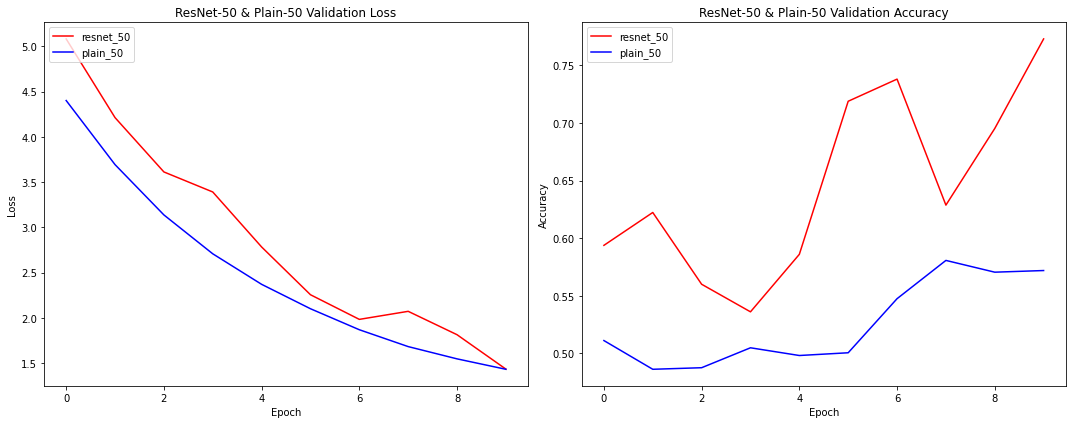

In [ ]:
plt.subplots(figsize=(15,6))

# ResNet-50, Plain-50 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_50.history['val_loss'], 'r')
plt.plot(history_plain_50.history['val_loss'], 'b')
plt.title('ResNet-50 & Plain-50 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

# ResNet-50, Plain-50 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('ResNet-50 & Plain-50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Validation_Loss_and_Accuracy_of_50.png')

plt.show()

- ResNet-34, Plain-34, ResNet-50, Plain-50
 - Validation Loss
 - Validation Accuracy

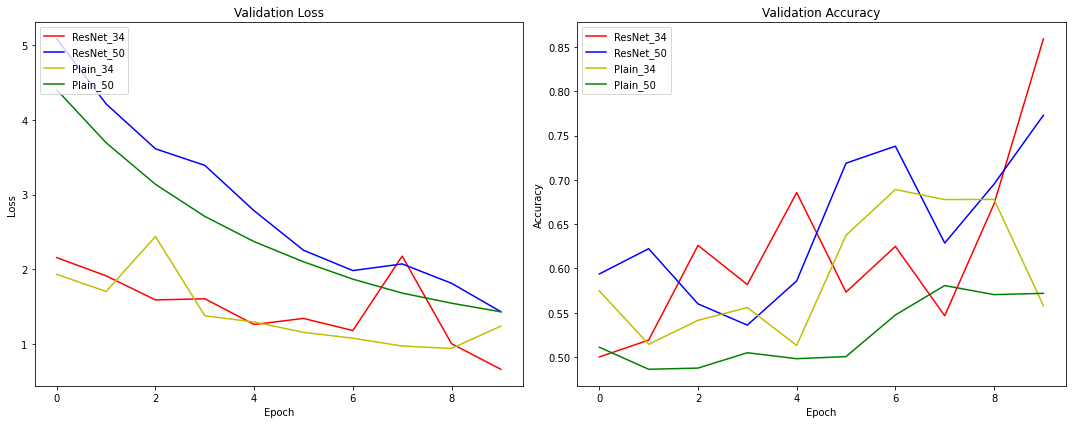

In [ ]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34, ResNet-50, Plain-50 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_resnet_50.history['val_loss'], 'b')
plt.plot(history_plain_34.history['val_loss'], 'y')
plt.plot(history_plain_50.history['val_loss'], 'g')
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

# ResNet-34, Plain-34, ResNet-50, Plain-50 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.plot(history_plain_34.history['val_accuracy'], 'y')
plt.plot(history_plain_50.history['val_accuracy'], 'g')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Validation_Loss_and_Accuracy_of_All.png')

plt.show()

#### 학습 결과 데이터 프레임으로 확인

- ResNet, Plain 학습 결과 데이터 프레임으로 저장


In [ ]:
# ResNet, Plain 학습 결과 평균값을 딕셔너리로 저장
model_result = {
    'ResNet-34': [
        round(np.array(history_resnet_34.history['loss']).mean(), 2),
        round(np.array(history_resnet_34.history['accuracy']).mean(), 2),
        round(np.array(history_resnet_34.history['val_loss']).mean(), 2),
        round(np.array(history_resnet_34.history['val_accuracy']).mean(), 2)
    ],
    'Plain-34': [
        round(np.array(history_plain_34.history['loss']).mean(), 2),
        round(np.array(history_plain_34.history['accuracy']).mean(), 2),
        round(np.array(history_plain_34.history['val_loss']).mean(), 2),
        round(np.array(history_plain_34.history['val_accuracy']).mean(), 2)
    ],
    'ResNet-50': [
        round(np.array(history_resnet_50.history['loss']).mean(), 2),
        round(np.array(history_resnet_50.history['accuracy']).mean(), 2),
        round(np.array(history_resnet_50.history['val_loss']).mean(), 2),
        round(np.array(history_resnet_50.history['val_accuracy']).mean(), 2)
    ],
    'Plain-50': [
        round(np.array(history_plain_50.history['loss']).mean(), 2),
        round(np.array(history_plain_50.history['accuracy']).mean(), 2),
        round(np.array(history_plain_50.history['val_loss']).mean(), 2),
        round(np.array(history_plain_50.history['val_accuracy']).mean(), 2)
    ],    
}

# 데이터 프레임 생성
df_model_result = pd.DataFrame(model_result, index=['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy'])
df_model_result

,ResNet-34,Plain-34,ResNet-50,Plain-50
Training Loss,1.30,1.31,2.97,2.68
Training Accuracy,0.73,0.64,0.70,0.54
Validation Loss,1.49,1.41,2.86,2.49
Validation Accuracy,0.62,0.59,0.65,0.53


- Validation Accuracy 기준으로 Ablation Study 결과표 작성


In [ ]:
df_val_acc = pd.DataFrame(df_model_result.loc['Validation Accuracy'], columns=['Validation Accuracy'])
df_val_acc

,Validation Accuracy
ResNet-34,0.62
Plain-34,0.59
ResNet-50,0.65
Plain-50,0.53


---

### 루브릭.

|평가문항|비고|상세기준|비고 |
|:---|:---:|:---|---:|
|esNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가? | |블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다. | |
|구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가? | |cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다. | |
|Ablation Study 결과가 바른 포맷으로 제출되었는가? | |esNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다. | |

---

### 회고록.

기존에는 구현되어있던 모델들을 이용해 CV 결과물을 출력해보는 프로젝트를 진행했었다면, 이번에는 ResNet논문과 여러 블록 구현 코드를 구글링과 framework 공식문서를 참고해 블록 함수를 직접 구성해 RssNet과 Plain net 레이어를 직접 구현해보고 결과물을 비교해보는 첫번째 고잉디퍼 프로젝트였다.  
처음 블록함수를 구현하고 논문에서 구현한 결과와 유사하게 나올 수 있도록 epoch를 설정하고 각 모델의 결과를 시각화하고 각 모델들의 accuray를 표로 정리했고 이러한 결과물들이 논문과 비슷한 결과가 나왔기에 굉장히 만족하고 있었다.  
낮은 값이여야 좋은 지표인 Training Loss, Validation Loss과 높은 값이여야 좋은 지표인 Training Accuracy, Validation Accuracy등이 학습이 진행될수록 PlainNet보다 ResNet이 더 좋은 성능을 보여주고 있었고 이는 논문에서 말하는 skip connection등 통해 성능을 개선했다는 내용과 같았기 때문이다.   
그러나 논문 리뷰와 스터디를 진행하면서 내가 여러 조건들을 무시한체 블록함수를 구현하고 학습을 진행했다는 사실을 깨달았다.  
원 목표는 여러 framework를 사용해서 프로젝트를 진행하는 것이 목표였는데 우선 지금 하고 있는 것부터 제대로 된 이해를 가지는게 우선이라고 느꼈다.  
특히 레이어가 깊을수록 학습의 accuracy가 올라갈거라고 섣부른 결론을 확정지은체 callback같은 기능들을 사용할 생각조차 하지 않은체 진행했었는데 데이터셋의 분류와 예측이 한정적이라면(이번 프로젝트 개vs고양이 라는 두개의 분류였기 때문에 학습을 진행할시 성능이 널뛰기 하는 모습을 보인다.) 과도한 레이어는 오히려 극단적인 결과물을 내놓을 수 있기에 오히려 좋은 성능을 끌어내기에 모델이 부적합할 수 있다는 것들을 이전 프로젝트를 진행하면서 알고있었던 것인데도 전혀 생각치 못했다는 것이 부끄러웠다.  
이번 프로젝트는 운이 좋게도 프로젝트의 결과가 원래 목표와 비슷했지만, 지속적으로 여러 방향으로 구현하고자 마음 먹었으니 파생 프로젝트에서 데이터셋 문제와 학습 횟수에 대한 여러 경험적인 노하우들을 쌓을 수 있도록 해야할 필요가 있음.  
논문 스터디를 진행할 때 관련지식들과 연결하고 논문 내용들을 구현하는 연습이 필요함.


----

### Reference. (APA)

Kaiming He, Xiangyu Zhang, ShaoqingRen, Jian Sun.(2015).Deep Residual Learning for Iamge Recognition. Microsoft Research. (https://arxiv.org/pdf/1512.03385.pdf)  

텐서플로우 공식문서.(2022).(https://www.tensorflow.org/tutorials/quickstart/beginner?hl=ko)  
텐서플로우 ResNet50 관련 API.(2022).(https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50)

kreas vs PyTorch 어떤 플랫폼을 선택해야할까?.(2022).(https://github.com/KerasKorea/KEKOxTutorial/blob/master/42_keras_or_pytorch_as_your_first_deep_learning_framework.md)

-----